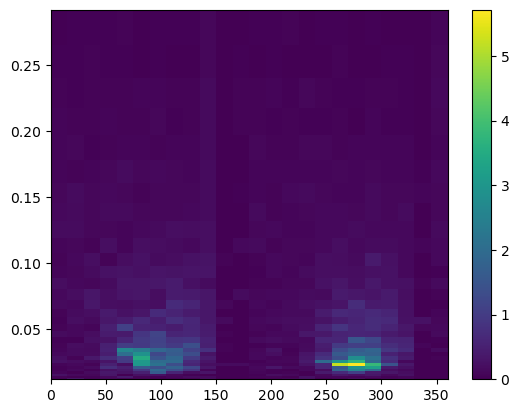

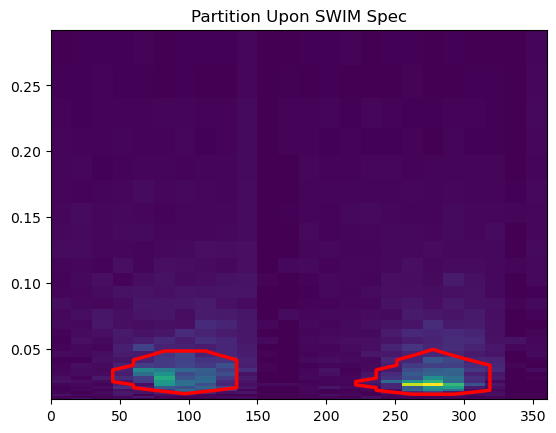

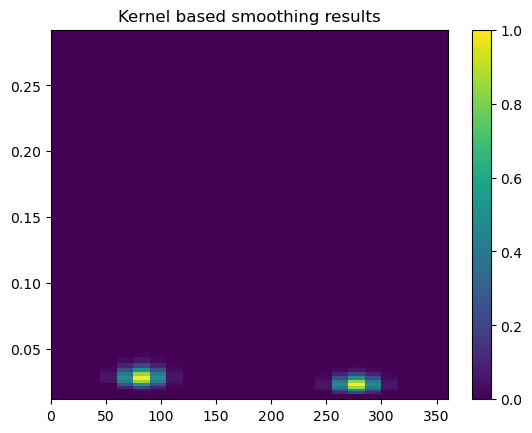

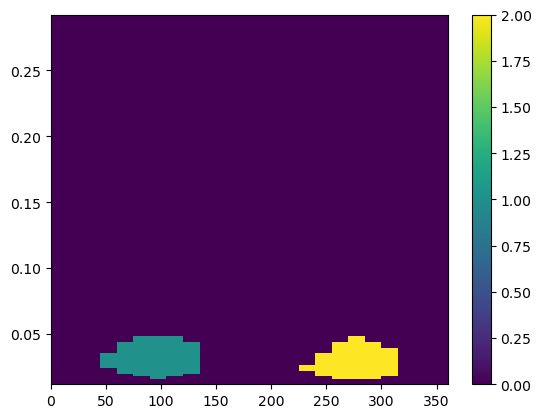

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import waveutils
from scipy import ndimage

swim_da_dir = "/home/shihaozou/scratch/data/CFOSAT/swim_covered_PAPA_2022.nc"

swim_da = xr.open_dataset(swim_da_dir)
swim_K = [0.012566, 0.013887, 0.015348, 0.016962, 0.018746, 0.020718, 
    0.022897, 0.025305, 0.027966, 0.030908, 0.034158, 0.037751, 0.041721, 
    0.046109, 0.050959, 0.056318, 0.062241, 0.068787, 0.076022, 0.084017, 
    0.092853, 0.102619, 0.113411, 0.125339, 0.138521, 0.153089, 0.16919, 
    0.186984, 0.206649, 0.228383, 0.252402, 0.278947]

swim_PHI = np.linspace(7.5, 360 - 7.5, 24) * np.pi / 180

PHI_mesh, K_mesh = np.meshgrid(swim_PHI, swim_K)

wave_spec = swim_da['pp_mean'].isel(time=0, n_beam_l2=2)

moment = swim_da['time'].isel(time=0).values

wave_spec = np.concatenate((wave_spec.values[:,:,0], wave_spec.values[:,:,1]), axis=1)
# wave_spec = np.concatenate((wave_spec, wave_spec), axis=1)

plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, wave_spec)
plt.colorbar()

nums, partition_index = waveutils.partition_waves_polar(K_mesh, PHI_mesh, wave_spec)

plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, wave_spec)
plt.contour(PHI_mesh*180/np.pi, K_mesh, partition_index, levels=[0.5], colors='red', linewidths=2.5)
plt.title(f"Partition Upon SWIM Spec")

gaussian_results = waveutils._kernel_based_partition_representation(wave_spec, partition_index)
plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, gaussian_results)
plt.colorbar()
plt.title("Kernel based smoothing results")


nums, partition_index_cart = waveutils.partition_waves(K_mesh, PHI_mesh, wave_spec, remove_invalid_parts=False)

plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index_cart)
plt.colorbar()

In [1]:
sar_da_dir = "/home/shihaozou/scratch/data/sentinel-1 L2 OCN/sar_covered_PAPA_2022.nc"
papa_da_dir = "/home/shihaozou/scratch/data/ocean_station_papa/PAPA_MEM2D.nc"

sar_da = xr.open_dataset(sar_da_dir)
papa_da = xr.open_dataset(papa_da_dir)
nearest_time_index = np.abs(papa_da['waveTime'] - moment).argmin()
papa_da_nearest = papa_da.isel(waveTime=nearest_time_index)

nearest_time_index = np.abs(sar_da['time'] - moment).argmin()
sar_da_nearest = sar_da.isel(time=nearest_time_index)
sar_moment = sar_da_nearest['time'].values
sar_spec = sar_da_nearest['oswQualityCrossSpectraIm'].values[0, 0, :, :]
sar_K = sar_da_nearest['oswK'].values
sar_PHI = sar_da_nearest['oswPhi'].values

sar_K_mesh, sar_PHI_mesh = np.meshgrid(sar_K, sar_PHI)

sar_spec, sar_K_mesh, sar_PHI_mesh = sar_spec.T, sar_K_mesh.T, sar_PHI_mesh.T

sar_spec2swim = waveutils.interpolate_wave_polar(sar_spec, sar_K, sar_PHI*np.pi/180, swim_K, swim_PHI)


sar_spec2swim[sar_spec2swim > 0] = 0
sar_spec2swim *= -1
_,  partition_index_sar = waveutils.partition_waves_polar(K_mesh, PHI_mesh, sar_spec2swim)
plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index, alpha=0.8, cmap='Reds')
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index_sar, alpha=0.3, cmap='Greens')
plt.title('Partition Index Comparison')
plt.xlabel('PHI (degree)')
plt.ylabel('wavenumber ($m^{-1}$)')


res = waveutils._kernel_based_partition_representation(sar_spec2swim, partition_index_sar)
plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, res)
plt.colorbar()


NameError: name 'xr' is not defined

In [ ]:
nearest_time_index

In [ ]:
plt.plot(sar_K)

In [ ]:
dphi = 2*np.pi / partition_index.shape[1]
    
rolling_column = int(np.round(np.pi / dphi))

partition_index_rolled = np.roll(partition_index, rolling_column, axis=1)

plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index, alpha=0.8, cmap='Reds')
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index_rolled, alpha=0.3, cmap='Greens')
plt.title('Partition Index Comparison')